In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow import keras

/Users/maxwood/opt/miniconda3/envs/deep_learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = pathlib.Path('country_vs_jazz')
img_height = 300
img_width = 300
batch_size = 32

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2673 files belonging to 2 classes.
Using 2139 files for training.


2022-06-12 22:04:00.375912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2673 files belonging to 2 classes.
Using 534 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['country', 'jazz']


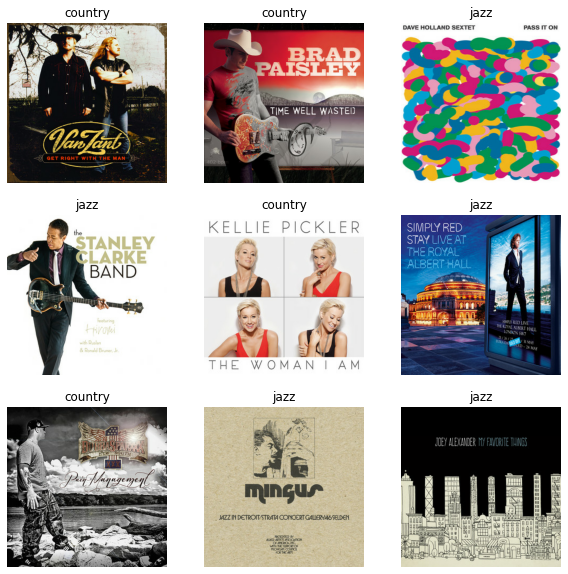

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Base Model

Start without transfer learning or drop out

In [27]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [28]:
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
67/67 [==============================] - 281s 4s/step - loss: 0.5724 - accuracy: 0.6919 - val_loss: 0.6924 - val_accuracy: 0.5637
Epoch 2/5
67/67 [==============================] - 268s 4s/step - loss: 0.5413 - accuracy: 0.7120 - val_loss: 0.6860 - val_accuracy: 0.5787
Epoch 3/5
67/67 [==============================] - 273s 4s/step - loss: 0.5189 - accuracy: 0.7302 - val_loss: 0.7006 - val_accuracy: 0.5787
Epoch 4/5
67/67 [==============================] - 243s 4s/step - loss: 0.5056 - accuracy: 0.7452 - val_loss: 0.7084 - val_accuracy: 0.6086
Epoch 5/5
67/67 [==============================] - 312s 5s/step - loss: 0.4625 - accuracy: 0.7784 - val_loss: 0.7163 - val_accuracy: 0.6049


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 71, 71, 32)       

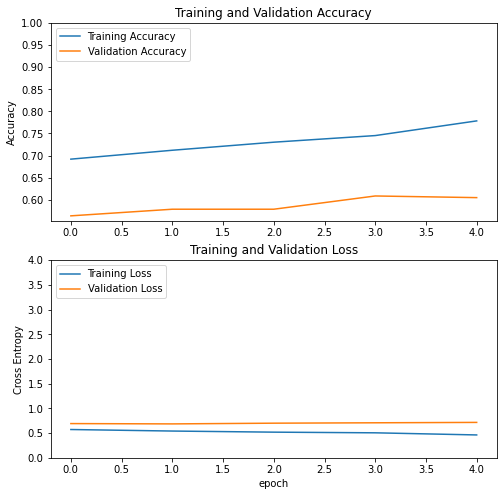

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)

In [32]:
y_prob = model.predict(val_ds)

17/17 [==============================] - 21s 1s/step


In [33]:
y_predict = y_prob.argmax(axis=-1)

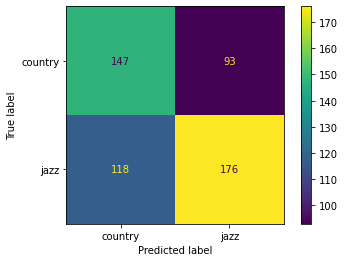

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix,
                               display_labels=class_names)
disp.plot()

Hmm Pretty bad :(, looks like we're overfitting a bit. Perhapps dropout can help.

### With Dropout added to our model

In [35]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.80, seed = 123),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [36]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [37]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
67/67 [==============================] - 361s 5s/step - loss: 0.7099 - accuracy: 0.5348 - val_loss: 0.6810 - val_accuracy: 0.5506
Epoch 2/10
67/67 [==============================] - 350s 5s/step - loss: 0.6789 - accuracy: 0.5432 - val_loss: 0.6790 - val_accuracy: 0.5487
Epoch 3/10
67/67 [==============================] - 346s 5s/step - loss: 0.6656 - accuracy: 0.5989 - val_loss: 0.6697 - val_accuracy: 0.5824
Epoch 4/10
67/67 [==============================] - 388s 6s/step - loss: 0.6386 - accuracy: 0.6279 - val_loss: 0.6663 - val_accuracy: 0.5543
Epoch 5/10
67/67 [==============================] - 269s 4s/step - loss: 0.5861 - accuracy: 0.6704 - val_loss: 0.7087 - val_accuracy: 0.5730
Epoch 6/10
67/67 [==============================] - 299s 4s/step - loss: 0.5488 - accuracy: 0.6994 - val_loss: 0.6904 - val_accuracy: 0.5787
Epoch 7/10
67/67 [==============================] - 239s 4s/step - loss: 0.5123 - accuracy: 0.7345 - val_loss: 0.7271 - val_accuracy: 0.5936
Epoch 8/10
67

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 32)       

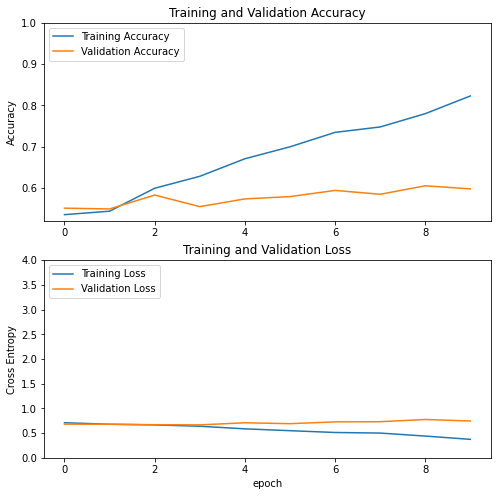

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [40]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)
y_prob = model.predict(val_ds)
y_predict = y_prob.argmax(axis=-1)

17/17 [==============================] - 13s 716ms/step


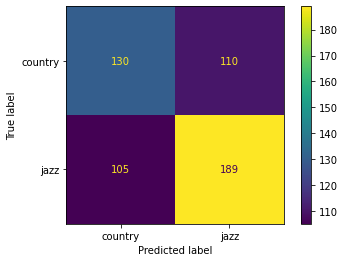

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix,
                               display_labels=class_names)
disp.plot()